In [1]:
#import libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as smf

In [2]:
#load data
data=pd.read_excel("C:\\Users\\Mahesh\Downloads\\Airlines+Data.xlsx")
data

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


## Data preprocessing and Visualization

In [3]:
data.shape

(96, 2)

In [4]:
data.head()

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


In [5]:
data.tail()

,Month,Passengers
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271
95,2002-12-01,306


In [6]:
data.dtypes

Month         datetime64[ns]
Passengers             int64
dtype: object

In [7]:
data.isna().sum()

Month         0
Passengers    0
dtype: int64

In [8]:
data.set_index('Month', inplace=True)
data.head()

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


In [9]:
data.describe()

,Passengers
count,96.000000
mean,213.708333
std,71.918216
min,104.000000
25%,156.000000
50%,200.000000
75%,264.750000
max,413.000000


<AxesSubplot:xlabel='Month'>

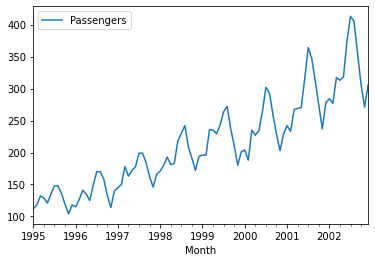

In [10]:
data.plot()

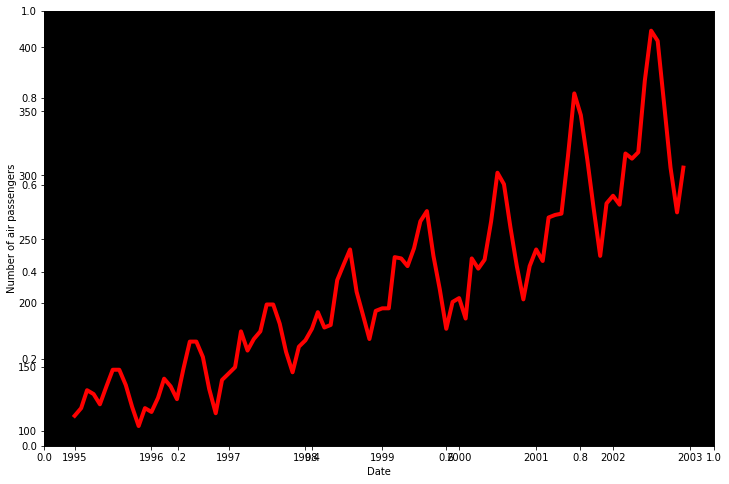

In [11]:
# Lineplot for Passengers
plt.figure(figsize=(12,8))
plt.xlabel("Date")
plt.ylabel("Number of air passengers")
ax = plt.axes()
ax.set_facecolor("black")
plt.plot(data['Passengers'], color = 'red', linewidth=4)


<AxesSubplot:>

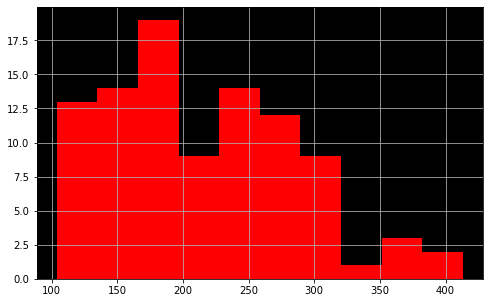

In [12]:
# Histogram
ax = plt.axes()
ax.set_facecolor("black")
data['Passengers'].hist(figsize=(8,5), color = 'red')

<AxesSubplot:ylabel='Density'>

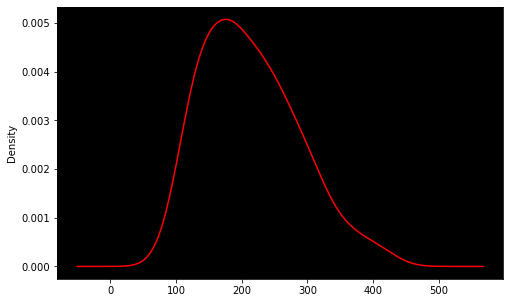

In [13]:
# Density Plot
ax = plt.axes()
ax.set_facecolor("black")
data['Passengers'].plot(kind = 'kde', figsize=(8,5), color = 'red')


### Time series decomposition plot

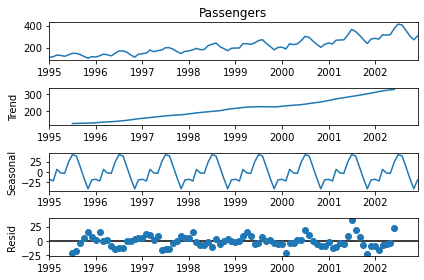

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_ts_add = seasonal_decompose(data.Passengers,period=12)
decompose_ts_add.plot()
plt.show()

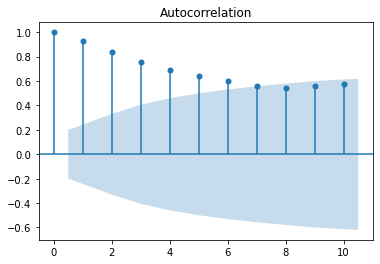

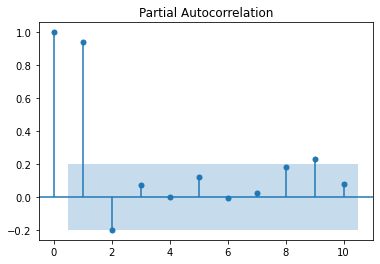

In [15]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(data.Passengers,lags=10)
tsa_plots.plot_pacf(data.Passengers,lags=10)
plt.show()

In [16]:
#seperate out a validation dataset 
split_point=len(data)-12
dataset, validation=data[0:split_point],data[split_point:]
print('Dataset %d Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv',header=False)

Dataset 84 Validation 12


## pesistence /Base model

In [17]:
# load data
train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = train.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]


In [18]:
print(train.shape,test.shape)

(42,) (42,)


In [19]:
history = [x for x in train]
print(history)

[112.0, 118.0, 132.0, 129.0, 121.0, 135.0, 148.0, 148.0, 136.0, 119.0, 104.0, 118.0, 115.0, 126.0, 141.0, 135.0, 125.0, 149.0, 170.0, 170.0, 158.0, 133.0, 114.0, 140.0, 145.0, 150.0, 178.0, 163.0, 172.0, 178.0, 199.0, 199.0, 184.0, 162.0, 146.0, 166.0, 171.0, 180.0, 193.0, 181.0, 183.0, 218.0]


In [20]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=218.000, Expected=230.000
>Predicted=230.000, Expected=242.000
>Predicted=242.000, Expected=209.000
>Predicted=209.000, Expected=191.000
>Predicted=191.000, Expected=172.000
>Predicted=172.000, Expected=194.000
>Predicted=194.000, Expected=196.000
>Predicted=196.000, Expected=196.000
>Predicted=196.000, Expected=236.000
>Predicted=236.000, Expected=235.000
>Predicted=235.000, Expected=229.000
>Predicted=229.000, Expected=243.000
>Predicted=243.000, Expected=264.000
>Predicted=264.000, Expected=272.000
>Predicted=272.000, Expected=237.000
>Predicted=237.000, Expected=211.000
>Predicted=211.000, Expected=180.000
>Predicted=180.000, Expected=201.000
>Predicted=201.000, Expected=204.000
>Predicted=204.000, Expected=188.000
>Predicted=188.000, Expected=235.000
>Predicted=235.000, Expected=227.000
>Predicted=227.000, Expected=234.000
>Predicted=234.000, Expected=264.000
>Predicted=264.000, Expected=302.000
>Predicted=302.000, Expected=293.000
>Predicted=293.000, Expected=259.000
>

## ARIMA Hyperparameters

In [21]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
# model_fit = model.fit(disp=0)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

## Grid search for p,d,q values¶

In [22]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [23]:
#load the data
train=pd.read_csv('dataset.csv',header=None,index_col=0,parse_dates=True,squeeze=True)
#evaluate parameters
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
evaluate_models(train.values,p_values,d_values,q_values )

ARIMA(0, 0, 0) RMSE=78.356
ARIMA(0, 0, 1) RMSE=44.790
ARIMA(0, 1, 0) RMSE=26.206
ARIMA(0, 1, 1) RMSE=25.582
ARIMA(0, 1, 2) RMSE=28.099
ARIMA(0, 1, 3) RMSE=23.953
ARIMA(0, 1, 4) RMSE=22.830
ARIMA(0, 2, 0) RMSE=32.545
ARIMA(0, 2, 1) RMSE=26.939
ARIMA(0, 2, 2) RMSE=26.175
ARIMA(0, 2, 3) RMSE=28.230
ARIMA(0, 2, 4) RMSE=25.209
ARIMA(1, 0, 0) RMSE=26.445
ARIMA(1, 0, 1) RMSE=25.611
ARIMA(1, 1, 0) RMSE=25.940
ARIMA(1, 2, 0) RMSE=31.784
ARIMA(2, 0, 0) RMSE=25.992
ARIMA(2, 1, 0) RMSE=25.659
ARIMA(2, 2, 0) RMSE=30.766
ARIMA(3, 0, 0) RMSE=25.820
ARIMA(3, 0, 1) RMSE=25.193
ARIMA(3, 1, 0) RMSE=25.765
ARIMA(3, 2, 0) RMSE=30.978
ARIMA(4, 0, 0) RMSE=26.056
ARIMA(4, 1, 0) RMSE=25.190
ARIMA(4, 2, 0) RMSE=29.503
ARIMA(4, 2, 1) RMSE=25.848
Best ARIMA(0, 1, 4) RMSE=22.830


 Best_ARIMA_MOdel, RMSE = 22.830

## Build Model based on the optimized values

In [24]:
#load data
train=read_csv('dataset.csv', header=0, index_col=0, parse_dates=True)
#prepare data
x=train.values
x= x.astype('float32')

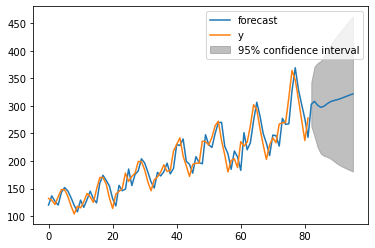

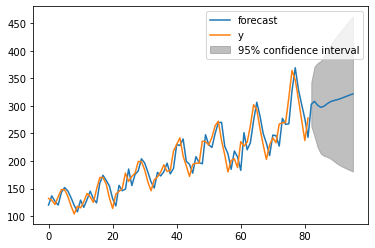

In [25]:
#fit model 
model=ARIMA(x,order=(3,1,0))
model_fit=model.fit()
forecast=model_fit.forecast(steps=12)[0]
model_fit.plot_predict(1,96)

In [26]:
#Error on the test data
val=pd.read_csv('validation.csv',header=None)
rmse = sqrt(mean_squared_error(val[1], forecast))
rmse

51.13515730096445

### combine train and test data , build final model

In [27]:
#fit model
x=train.values
x=x.astype('float32')

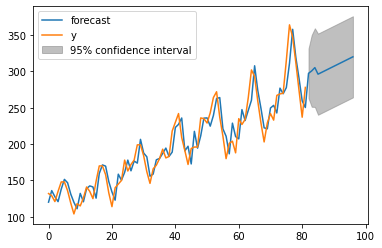

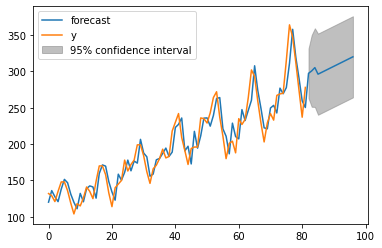

In [28]:
model=ARIMA(x,order=(0,1,4))
model_fit=model.fit()
forecast=model_fit.forecast(steps=12)[0]
model_fit.plot_predict(1,97)

In [29]:
forecast

array([297.29504686, 300.66281914, 305.18875163, 296.16873356,
       298.33910981, 300.50948606, 302.67986231, 304.85023856,
       307.02061482, 309.19099107, 311.36136732, 313.53174357])